## Importing liberaries

In [68]:
import optuna
# import wandb
import logging
import sys
import os
import tensorflow as tf
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, Bidirectional, MaxPooling1D, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import AdditiveAttention, Concatenate, BatchNormalization, Activation, MultiHeadAttention, LayerNormalization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, Callback

## Loading the data

In [69]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


In [70]:
# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_text.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy().flatten()

In [71]:
all_texts_length = X_df['Processed'].apply(lambda x: len(x.split()))
# Now, let's analyze the distribution of these sequence lengths
all_texts_length.describe()

count    12854.000000
mean        23.089311
std         86.574861
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max       2292.000000
Name: Processed, dtype: float64

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>') # Hyperparameters = num_words=vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(X)

#Creating a word index of the words from the tokenizer 
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.\n\nFirst 10 is listen below:')
print(dict(list(word_index.items())[0:10]))

Found 22234 unique tokens.

First 10 is listen below:
{'<OOV>': 1, 'people': 2, 'like': 3, 'work': 4, 'right': 5, 'trump': 6, 'think': 7, 'state': 8, 'government': 9, 'party': 10}


In [73]:
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.7)

# if isinstance(X, np.ndarray):
#     X = X.tolist()

# # Ensure each element is a string
# X = [str(doc) for doc in X]

# # Fit and transform the documents
# X_tfidf = vectorizer.fit_transform(X)

# # To get feature names (which includes the n-grams)
# feature_names = vectorizer.get_feature_names_out()

# # Convert the TF-IDF matrix to a dense format to print it
# dense_features = X_tfidf.todense()

# # Printing the dense matrix and the feature names to understand what it looks like
# print(dense_features)
# print(feature_names)

In [74]:
# Defining pre-processing hyperparameters for the networks
max_len = 100
trunc_type = "post"
padding_type = "post"
vocab_size = len(word_index)
# This is fixed.
embedding_dim = 100
EPOCHS=20
BATCH_SIZE = 32
num_classes = 1

In [75]:
# Encoding the sequences from the reddit posts
X = tokenizer.texts_to_sequences(X)
# Padding the sequences to keep the lengths uniform
X = pad_sequences(X, maxlen=max_len, padding=padding_type, truncating=trunc_type)
# print('Shape of data tensor:', X_tensorflow.shape)

## TF-IDF vectorizer

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [77]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [78]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open(r'C:\Users\bugat\Prosjekter\Tekstanalyse\git_NLP\Tekstanalyse\git_NLP_Notebooks\Hypertuning_trials\best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## The LSTM-CNN model with tuned hyperparameters and attention layer

In [79]:
# # extracting the parameters
# lstm_units = params['lstm_units']
# dense_1_units = params['dense_1_units']
# dense_2_units = params['dense_2_units']
# dropout_rate = params['dropout_rate']
# learning_rate = params['learning_rate']

In [80]:
class ModelConfig:
    def __init__(self, max_len, num_classes, embeddings_GloVe):
        self.max_len = max_len
        self.num_classes = num_classes
        self.embeddings_GloVe = embeddings_GloVe


# Create a configuration object
config = ModelConfig(max_len=max_len, num_classes=num_classes, embeddings_GloVe=embeddings_GloVe)

In [81]:
def CNN_LSTM_sequential(params, config):
    input_layer = Input(shape=(config.max_len,), dtype='int32')
    
    # Use config object for fixed parameters such as embeddings
    embedding = Embedding(input_dim=config.embeddings_GloVe.shape[0],
                          output_dim=config.embeddings_GloVe.shape[1],
                          weights=[config.embeddings_GloVe],
                          trainable=False)(input_layer)
    
    # Use params dictionary for dynamic hyperparameters
    dropout = Dropout(params['dropout_rate'])(embedding)

    conv = Conv1D(filters=params['conv_filters'], kernel_size=1, activation='relu')(dropout)
    conv = BatchNormalization()(conv)

    lstm = Bidirectional(LSTM(params['lstm_units'], return_sequences=True, dropout=0.006, recurrent_dropout=0.1))(conv)
    lstm = LayerNormalization()(lstm)
    
    num_heads = 8
    attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=config.embeddings_GloVe.shape[1] // num_heads, dropout=0.1)
    attention_output = attention_layer(query=lstm, key=lstm, value=lstm)
    attention_output = LayerNormalization()(attention_output)

    dense = Dense(params['dense_2_units'], activation='relu')(attention_output)
    dense = BatchNormalization()(dense)
    output = Dense(config.num_classes, activation='sigmoid')(dense)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(params['learning_rate']), metrics=['accuracy'])
    
    return model

In [ ]:
import sys
import logging
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from optuna.integration import KerasPruningCallback
import optuna_dashboard
import os


# Define the objective function including the logging of each trial's outcome
def objective(trial):
    # wandb.init(project="optuna_with_wandb", entity="your_entity_here", reinit=True)
    params = {
        'lstm_units': trial.suggest_int('lstm_units', 100, 150, step=5),
        # 'dense_1_units': trial.suggest_int('dense_1_units', 100, 150, step=5),
        'dense_2_units': trial.suggest_int('dense_2_units', 100, 150, step=5),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.2, 0.5),
        # 'lstm_dropout': trial.suggest_float('lstm_dropout', 0.0, 0.2),
        # 'lstm_recurrent': trial.suggest_float('lstm_recurrent', 0.0, 0.2),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'conv_filters': trial.suggest_int('conv_filters', 32, 64, step=2)
    }

    # # Log hyperparameters to wandb
    # wandb.config.update(params)

    # Build and train the model
    model = CNN_LSTM_sequential(params, config)

    #Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    pruning_callback = KerasPruningCallback(trial, 'val_loss')  # Create a pruning callback
    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10,
                        callbacks=[early_stopping, pruning_callback], batch_size=32, verbose=1)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    
    # Log final metrics to wandb
    # wandb.log({"loss": loss, "accuracy": accuracy})

    # Ensure wandb run is finished after each trial
    # wandb.finish()
    
    # trial.report(accuracy, 1)  # Report the accuracy to Optuna
    return accuracy 


# Setup Optuna with persistent storage
storage_url = "sqlite:///db.sqlite3"
study_name = 'Proto_koer'
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.TPESampler(), 
                            study_name=study_name, 
                            storage=storage_url, 
                            pruner=optuna.pruners.MedianPruner(),  # Adding a pruner
                            load_if_exists=True)

study.optimize(objective, n_trials=100)
print(f"Best value: {study.best_value} (params: {study.best_params})")

In [88]:
print("Best trial:")
trial = study.best_trial
print(f" Best Validation Accuracy: {trial.value}")  # Convert back to positive to display
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
 Best Validation Accuracy: 0.7689781785011292
 Params: 
    lstm_units: 140
    dense_2_units: 150
    dropout_rate: 0.42803898610506674
    learning_rate: 0.000922823163674921
    conv_filters: 52


In [89]:
#creating a dictionary for the trial data
trial_data = {
    'number': trial.number,
    'params': trial.params,
    'value': trial.value
}

# Saving the trials to json files
with open('best_trial_length_100.json', 'w') as f:
    json.dump(trial_data, f)

In [93]:
# Retrieve the best model
best_params = study.best_trial.params

best_model = CNN_LSTM_sequential(best_params, config)

best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)
# Retrain on the full training data

# Evaluate on the test data
loss_1, accuracy_1 = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy_1}")

Epoch 1/20
282/282 [==============================] - 214s 710ms/step - loss: 0.6455 - accuracy: 0.6455 - val_loss: 0.5995 - val_accuracy: 0.6773
Epoch 2/20
282/282 [==============================] - 224s 794ms/step - loss: 0.6040 - accuracy: 0.6737 - val_loss: 0.5805 - val_accuracy: 0.6968
Epoch 3/20
282/282 [==============================] - 240s 853ms/step - loss: 0.5895 - accuracy: 0.6898 - val_loss: 0.5664 - val_accuracy: 0.6991
Epoch 4/20
282/282 [==============================] - 244s 866ms/step - loss: 0.5719 - accuracy: 0.7047 - val_loss: 0.5680 - val_accuracy: 0.6985
Epoch 5/20
282/282 [==============================] - 243s 861ms/step - loss: 0.5604 - accuracy: 0.7136 - val_loss: 0.5232 - val_accuracy: 0.7518
Epoch 6/20
282/282 [==============================] - 240s 852ms/step - loss: 0.5499 - accuracy: 0.7198 - val_loss: 0.5636 - val_accuracy: 0.6901
Epoch 7/20
282/282 [==============================] - 241s 855ms/step - loss: 0.5343 - accuracy: 0.7361 - val_loss: 0.5245 -

In [85]:
# num_classes = 1
# EPOCHS=20
# BATCH_SIZE = 32

# model = CNN_LSTM_sequential(max_len, lstm_units, dense_1_units, dense_2_units, dropout_rate, learning_rate, num_classes, embeddings_GloVe)

# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0000001)


# history = model.fit(X_train, y_train,
#                     epochs=20,
#                     validation_data=(X_val, y_val),
#                     batch_size=BATCH_SIZE,
#                     callbacks=early_stopping_callback
#                     )

In [86]:
model.summary()

NameError: name 'model' is not defined

## Evaluation of the model

In [97]:
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

61/61 [==============================] - 9s 141ms/step - loss: 0.4918 - accuracy: 0.7712
Test Loss: 0.49180325865745544
Test Accuracy: 0.771155834197998


TypeError: 'History' object is not subscriptable

## Classification metrics

31/31 [==============================] - 11s 335ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       681
           1       0.79      0.89      0.84      1248

    accuracy                           0.78      1929
   macro avg       0.76      0.73      0.74      1929
weighted avg       0.77      0.78      0.77      1929

Accuracy: 0.7750129600829445
Recall: 0.8902243589743589
Precision: 0.7890625
F1 Score: 0.8365963855421685


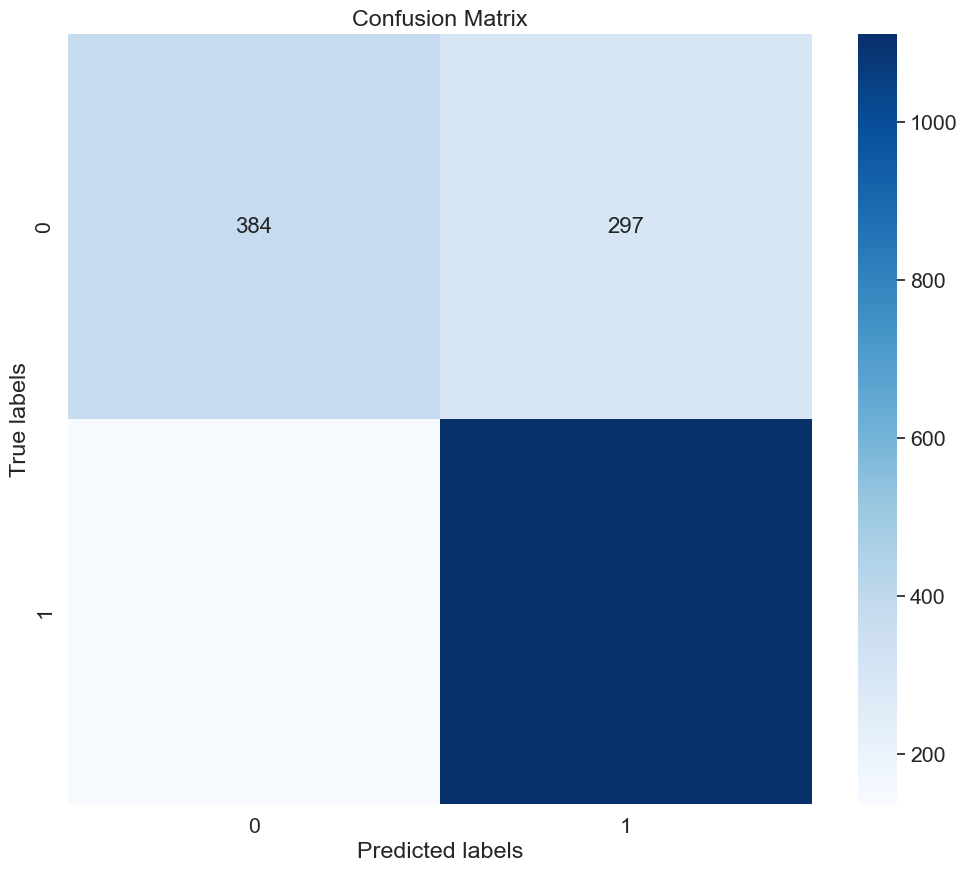

In [99]:
# Predict probabilities for the positive class (class 1)
probabilities = best_model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
# y_pred = (probabilities > 0.5).astype(int).flatten()
y_pred = (probabilities[:, 0] > 0.5).astype(int)  # Indexing the first column if necessary


# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()